**Auteur du document** : V. Joan Aléonard<br>
**Date de modification** : 17-12-2020

# <center><font color=red>CONSTRUIRE UN MODELE DE SCORING</font></center>

![picture](https://drive.google.com/uc?id=12i0gwEMO3ynOn5sspA30BTenKdw_hloT)

**Prêt à dépenser** propose des crédits à la consommation pour une **cible de clientèle spécifique** : des **personnes ayant peu ou pas d'historique de prêt**, souvent sans compte en banque.

En effet, ces personnes ont souvent du mal à obtenir des prêts en raison de cette insuffisance ou inexistance d'antécédents de crédit. Prêt à dépenser s'assure que cette population mal desservie ait une expérience positive en matière de prêt.

Néanmoins, prédire si un client remboursera un prêt ou s'il aura des difficultés est un **besoin critique** pour Prêt à dépenser.

L'entreprise veut ainsi **exploiter le potentiel des données** à sa disposition pour voir quel type de modèles d'apprentissage automatique (*Machine Learning*) peut être développé pour l'aider dans cette tâche.

**<center><font color=green>LA MISSION</font></center>**

Notre mission, en tant que Data Scientist, est de développer un **modèle de scoring** pour prédire **<font color=red>la probabilité de défaut de paiement d'un client</font>**, car si on peut déplorer le rejet des demandes de prêt de clients capables de rembourser (manque à gagner), accepter des demandes de prêt de clients incapables de rembourser est hautement préjudiciable pour l'entreprise (perte d'argent réelle).

**<center><font color=green>LA PROBLEMATIQUE DE MACHINE LEARNING</font></center>**

On est ici face à une problématique de **classification supervisée** :
- **classification**, car la variable cible (target) est binaire (classe discrète) : 
  - **0 (va rembourser)** = SOLVABLE ;
  - **1 (ne va pas rembourser / aura des difficultés)** = NON-SOLVABLE ;
- **supervisée**, car les valeurs (étiquettes /labels) sont incluses dans les données et l'objectif est d'apprendre au modèle à prédire à partir de ces exemples ou observations.

Néanmoins, il faut faire attention à la **métrique** attendue, qui n'est pas de prédire les valeurs de la variable cible (0 ou 1), mais de prédire une **probabilité de défaut de paiement comprise entre 0% (pas de risque de défaut de paiement) et 100% (risque maximum de défaut de paiement)**.

**<center><font color=green>LE LIVRABLE</font></center>**

Le **modèle de scoring** sera utilisé par les **chargés de relation client** qui vont **décider** si un prêt peut être accordé ou non à un client. 

Le modèle doit donc :
- être facilement interprétable afin d'expliquer le score attribué à un client ;
- disposer d'une mesure de l'importance des variables qui ont influencées la probabilité prédite par le modèle.

Le modèle ne suffit pas en lui-même pour prendre une décision aussi nous allons adosser au résultat prédit par le modèle une **métrique business** afin que les chargés de clientèle aient en leur possession un outil plus complet pour justifier leur décision, autant vis-à-vis du client que par rapport aux objectifs de l'entreprise.

---

#### Utilisation de kernels Kaggle

Ce notebook ne se focalisera pas sur les étapes d'exploration et de préparation des données. 

Nous utiliserons des kernels Kaggle pour ces étapes et nous développerons en détail la modélisation.
- https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction
- https://www.kaggle.com/aantonova/collection-of-useful-functions-and-simple-baseline

---

#### Importation des librairies essentielles

In [2]:
# -*- coding: uft-8 -*-

# Pour la manipulation de données
import numpy as np # algèbre linéaire
import pandas as pd # data processing, CSV file I/O

# Pour la visualisation de données
import matplotlib.pyplot as plt
import seaborn as sns
# plt.rcParams["axes.facecolor"] = "#f9f9f9"
sns.set_style("whitegrid")
%matplotlib inline

# Pour les interactions avec le système d'exploitation (HORS google colab)
# import os
# os.chdir("C:/Users/LaFamille/Documents/_Ingénieur_IA/Projet_4")
# print(os.listdir())

# Pour la gestion de l'utilisation de la mémoire
import gc

# Pour la gestion des alertes
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

---

#### Helper function : réduction usage mémoire et visualisation des valeurs manquantes

In [3]:
# Fonction pour vérifier la consommation mémoire d'un df avec la méthode memory_usage de Pandas
def memory_usage_mb(df, *args, **kwargs):
    """Consommation de mémoire d'un dataframe en MB. """
    return df.memory_usage(*args, **kwargs).sum() / 1024**2

# Fonction réplicable pour réduire l'usage de la mémoire par des formats de données trop gourmands 
# PREMIERS CODES TROUVES, pitfall sur les float<32 || https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# SOLUTION GUIFERVIZ sur Kaggle || https://www.kaggle.com/c/champs-scalar-coupling/discussion/96655
def reduce_memory_usage(df, deep=True, verbose=True, categories=True):
    """ convertit le type de données (downcast) de certaines colonnes pour réduire l'utilisation de la mémoire       
    """
    # Type de données qu'on veut alléger (downcast)
    numeric2reduce = ["int16", "int32", "int64", "float64"]
    start_mem = 0
    if verbose:
        start_mem = memory_usage_mb(df, deep=deep)

    for col, col_type in df.dtypes.iteritems():
        best_type = None
        if col_type == "object":
            df[col] = df[col].astype("category")
            best_type = "category"
        elif col_type in numeric2reduce:
            downcast = "integer" if "int" in str(col_type) else "float"
            df[col] = pd.to_numeric(df[col], downcast=downcast)
            best_type = df[col].dtype.name
        # Afficher la conversion effectuée
        #if verbose and best_type is not None and best_type != str(col_type):
            #print(f"Colonne '{col}' convertit de {col_type} à {best_type}")

    if verbose:
        end_mem = memory_usage_mb(df, deep=deep)
        diff_mem = start_mem - end_mem
        percent_mem = 100 * diff_mem / start_mem
        print(f"Réduction d'utilisation de la mémoire de "
              f" {start_mem:.2f}MB à {end_mem:.2f}MB"
              f" (soit {percent_mem:.2f}% de réduction)")
        

# Fonction pour calculer les valeurs manquantes par colonne
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()
        
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
        
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : "Valeurs manquantes", 1 : "% vs Total"})
        
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        "% vs Total", ascending=False).round(1)
        
    # Print some summary information
    print("Le dataframe a " + str(df.shape[1]) + " colonnes.\n"
          "Il y a " + str(mis_val_table_ren_columns.shape[0]) + 
          " colonnes avec des valeurs manquantes.")
        
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

# <font color=red>PARTIE 1 - TRAITEMENT SUR APPLICATION TRAIN</font>

Nous utiliserons surtout la base de données principale "**application_train**" qui donne des informations suivantes :
- des **données personnelles** sur de demandeur : sexe, âge en jours au moment de la demande, situation familiale, nombre d'enfants, occupation, revenus, niveau d'études, information sur le lieu de vie, les biens matériels (voiture, maison, téléphone,..), etc.
- des **données relatives au crédit** : identifiant unique, type de crédit, montant du crédit, montant des annuités, documents fournis, etc.
- des informations (scores) externes : il semblerait que les institutions financières puissent acheter des scores pour qualifier un dossier de crédit, mais il n'est pas possible de savoir comment ces scores ont été constitués ;
- ET surtout, la **variable cible** qui est "**TARGET**"

> **REMARQUE** : <br>
Les valeurs de la variable cible TARGET n'étant pas fournies dans le jeu de données "**application_test**", nous n'allons pas l'utiliser spécifiquement pour mesurer la performance du modèle qui sera sélectionné.<br><br>
Néanmoins, durant la phase de préparation des données, nous appliquement des étapes nécessaires **d'alignement** des TRAIN et TEST sets comme si on pouvait utiliser ce dernier, afin que toutes les données soint **représentées de manière IDENTIQUE** dans les deux bases. <br><br>
Autrement, pour d'autres cas de figure où les données seraient disponibles dans le TEST set, l'apprentissage serait biaisé et cela aurait évidemment un impact conséquent sur la performance de modèle lors de la prédiction.

## <font color=green>1.1 - Chargement et alignement des données</font>

### <font color=blue>1.1.1 - Vue d'ensemble des données</font>

In [4]:
# Charger les 2 datasets
# A partir de Google Colab
df_train = pd.read_csv("/content/drive/My Drive/_Ingénieur_IA/P04/application_train.csv")
df_test = pd.read_csv("/content/drive/My Drive/_Ingénieur_IA/P04/application_test.csv")
# A partir de Jupyter (Anaconda)
# df_train = pd.read_csv("application_train.csv")
# df_test = pd.read_csv("application_test.csv")

print("Train : {}, Test : {}".format(df_train.shape, df_test.shape))
print("Train % : {}, Test % : {}".format(round(100 * len(df_train) /(len(df_train)+len(df_test)), 0), 
                                         round(100 * len(df_test) / (len(df_train)+len(df_test)), 0)))

Train : (307511, 122), Test : (48744, 121)
Train % : 86.0, Test % : 14.0


Le dataset TRAIN présente :
- 307.511 clients demandeurs de prêt ;
- caractéristés par 121 variables ;
- plus la cible à prédire : "TARGET".

In [5]:
# Vérifier les valeurs de 'TARGET' dans le TRAIN set
df_train["TARGET"].value_counts(dropna=False)

0    282686
1     24825
Name: TARGET, dtype: int64

In [6]:
# Vérifier les valeurs de 'TARGET' dans le TRAIN set (en pourcentage)
round(df_train["TARGET"].value_counts(normalize=True) * 100, 1)

0    91.9
1     8.1
Name: TARGET, dtype: float64

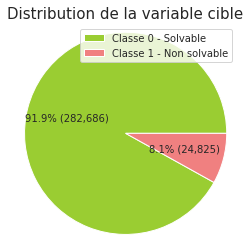

In [7]:
# Représenter graphiquement : diagramme en secteurs
plt.figure(figsize=(4,4))
values = df_train["TARGET"].value_counts()
colors = ["yellowgreen", "lightcoral"]
labels = ["Classe 0 - Solvable", "Classe 1 - Non solvable"]
plt.pie(values, colors=colors, autopct=lambda p: "{:.1f}% ({:,.0f})".format(p, p *sum(values)/100))
plt.title("Distribution de la variable cible", fontsize=15)
plt.legend(labels, loc="upper right")
plt.ylabel("")
plt.axis("equal")
plt.show()

Nous avons ici une grande disparité des classes à prédire : on dit que **les données sont déséquilibrées (*imbalanced data*)** car la classe 0 - qui représente les clients qui ont remboursé leur prêt, est prépondérante (majoritaire) comparée à la classe 1 - qui représente les clients qui n'ont pas remboursé leur prêt (minoritaire). 

Cette information est très importante car elle va influencer la manière dont nous allons :
- **paramétrer nos modèles** pour qu'ils n'aient pas tendance à prédire systématiquement à la classe majoritaire ;
- **choisir les métriques** d'évaluation adaptés : par exemple, la métrique *accuracy* n'est pas adaptée lorsque les données sont déséquilibrées.

### <font color=blue>1.1.2 - Alignement des données du Train et Test set</font>

Comme expliquer en introduction de la partie 1, nous allons vérifier si les données du TRAIN set et du TEST set **possèdent les mêmes informations** afin de les aligner si ce n'est pas le cas : le modèle ne pourrait pas reconnaître les features qu'il a appris durant l'entraînement avec la même précision.

**On va donc vérifier - pour chaque feature, s'il y a des valeurs (étiquettes) différentes entre les 2 jeux de données**.

In [8]:
# Contrôler les différences de valeurs uniques de chaque variable catégorielle des 2 dataframes
for col in df_train.columns[df_train.dtypes == "object"]:
    col_train = set(df_train[col].unique())
    col_test = set(df_test[col].unique())
    diff = col_train ^ col_test
    if len(diff) > 0 :
        print("La variable " + col + " a des étiquettes différentes: ", diff)

La variable CODE_GENDER a des étiquettes différentes:  {'XNA'}
La variable NAME_INCOME_TYPE a des étiquettes différentes:  {'Maternity leave'}
La variable NAME_FAMILY_STATUS a des étiquettes différentes:  {'Unknown'}


Nous avons 3 features pour lesquelles les valeurs sont différentes dans le TRAIN SET : nous allons les **exclure**.

In [9]:
# Supprimer du TRAIN les valeurs non communes sur les features sélectionnées
df_train = df_train[df_train["CODE_GENDER"] != "XNA"]
df_train = df_train[df_train["NAME_INCOME_TYPE"] != "Maternity leave"]
df_train = df_train[df_train["NAME_FAMILY_STATUS"] != "Unknown"]

# Vérifier sur l'une des features
df_train["CODE_GENDER"].value_counts(dropna=False)

F    202443
M    105057
Name: CODE_GENDER, dtype: int64

In [10]:
# Afficher les premières lignes avec l'intégralité des colonnes
pd.options.display.max_columns = df_train.shape[1]
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

## <font color=green>1.2 - Nettoyage des données</font>

### <font color=blue>1.2.1 - Correction anomalies</font>

La feature <code>DAYS_EMPLOYED</code> présente des valeurs extrêmes (1000 ans) que nous allons remplacer par NaN.

In [11]:
# Afficher les statistiques de base
df_train["DAYS_EMPLOYED"].describe()

count    307500.000000
mean      63817.429333
std      141277.730537
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [12]:
# Remplacer la valeur extrême par NaN
df_train["DAYS_EMPLOYED"].replace(365243, np.nan, inplace=True)
df_test["DAYS_EMPLOYED"].replace(365243, np.nan, inplace=True)

# Afficher les statistiques de base
df_train["DAYS_EMPLOYED"].describe()

count    252126.000000
mean      -2384.150631
std        2338.349929
min      -17912.000000
25%       -3175.000000
50%       -1648.000000
75%        -767.000000
max           0.000000
Name: DAYS_EMPLOYED, dtype: float64

### <font color=blue>1.2.2 - Suppression colonnes avec trop de valeurs manquantes</font>

Nous supprimons les colonnes qui ont plus de 60% de valeurs manquantes.

In [13]:
# Afficher des statistiques de valeurs manquantes
missing_values = missing_values_table(df_train)
missing_values.head(10)

Le dataframe a 122 colonnes.
Il y a 67 colonnes avec des valeurs manquantes.


,Valeurs manquantes,% vs Total
COMMONAREA_MEDI,214856,69.9
COMMONAREA_AVG,214856,69.9
COMMONAREA_MODE,214856,69.9
NONLIVINGAPARTMENTS_MEDI,213506,69.4
NONLIVINGAPARTMENTS_MODE,213506,69.4
NONLIVINGAPARTMENTS_AVG,213506,69.4
FONDKAPREMONT_MODE,210289,68.4
LIVINGAPARTMENTS_MODE,210191,68.4
LIVINGAPARTMENTS_MEDI,210191,68.4
LIVINGAPARTMENTS_AVG,210191,68.4


In [14]:
# Créer une liste de colonnes à supprimer
seuil = 60
missing_columns = missing_values[missing_values["% vs Total"] >= seuil].index

# Supprimer les features peu informatives
df_train.drop(missing_columns, axis=1, inplace=True)
df_test.drop(missing_columns, axis=1, inplace=True)
print("Train :", df_train.shape, "Test :", df_test.shape)

Train : (307500, 105) Test : (48744, 104)


## <font color=green>1.3 - Feature engineering</font>

### <font color=blue>1.3.1 - Encodage des variables catégorielles</font>

**Encoder** signifie **convertir des variables catégorielles en variables numériques**.

Notre stratégie d'encodage est la suivante :
- Utiliser la méthode **LabelEncoder de Scikit-learn** pour les variables avec des classes binaires (2 valeurs) ;
- Utiliser la fréquence des classes des variables pour celles dont les classes sont supérieures à 2 : cette méthode évite de créer des colonnes supplémentaires comme lorsque la méthode **get_dummies de Pandas** est utilisée et de se retrouver face à une problématique de ***fléau de la dimensionalité***.

In [15]:
# Affichir les valeurs uniques par feature
df_train.select_dtypes("object").apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [16]:
# Pour le preprocessing des données
# Encoder les variables catégorielles
from sklearn.preprocessing import LabelEncoder

# Obtenir la liste des variables catégorielles
object_list = df_train.select_dtypes("object").columns

# Instancier l'objet LabelEncoder de sklearn
lbe = LabelEncoder()
# Initier un comptage des variables catégorielles à encoder
lbe_count = 0

# Encoder par la fréquence pour éviter d'avoir un surplus de colonnes
for col in object_list:
    new_label = df_train[col].value_counts()
    if df_train[col].nunique(dropna=False) <= 2:
        # Entraîner le LabelEncoder et transformer les données
        df_train[col] = lbe.fit_transform(df_train[col])
        df_test[col] = lbe.fit_transform(df_test[col])
        # Traquer le nombre de variables encodées
        lbe_count += 1
    else:
        # Attribuer à chaque étiquette sa fréquence et convertir le résultat en float
        # Cela évite la création de colonnes additionnelles
        df_train[col] = df_train[col].map(new_label).astype(float)
        df_test[col] = df_test[col].map(new_label).astype(float)

print("%d colonne(s) sont encodées avec LabelEncoder." % lbe_count)
    
# Afficher les 1ères lignes
pd.options.display.max_columns = df_train.shape[1]
print("Train :", df_train.shape, "Test :", df_test.shape)
df_train.head()

4 colonne(s) sont encodées avec LabelEncoder.
Train : (307500, 105) Test : (48744, 104)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,248520.0,158771.0,218387.0,45444.0,272859.0,0.018801,-9461,-637.0,-3648.0,-2120,1,1,0,1,1,0,55185.0,1.0,2,2,51934.0,10,0,0,0,0,0,0,67992.0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.00,0.0690,0.0833,0.0369,0.0190,0.0000,0.0252,0.0383,0.9722,0.0000,0.0690,0.0833,0.0377,0.0198,0.0,0.0250,0.0369,0.9722,0.00,0.0690,0.0833,0.0375,0.0193,0.00,150497.0,0.0149,64812.0,159422.0,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,40148.0,21703.0,74858.0,196424.0,272859.0,0.003541,-16765,-1188.0,-1186.0,-291,1,1,0,1,1,0,27567.0,2.0,1,1,50712.0,11,0,0,0,0,0,0,8893.0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.08,0.0345,0.2917,0.0130,0.0549,0.0098,0.0924,0.0538,0.9851,0.0806,0.0345,0.2917,0.0128,0.0554,0.0,0.0968,0.0529,0.9851,0.08,0.0345,0.2917,0.0132,0.0558,0.01,150497.0,0.0714,9253.0,159422.0,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,248520.0,158771.0,218387.0,45444.0,272859.0,0.010032,-19046,-225.0,-4260.0,-2531,1,1,1,1,1,0,55185.0,1.0,2,2,50712.0,9,0,0,0,0,0,0,10404.0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,248520.0,158771.0,218387.0,29774.0,272859.0,0.008019,-19005,-3039.0,-9833.0,-2437,1,1,0,1,0,0,55185.0,2.0,2,2,51934.0,17,0,0,0,0,0,0,67992.0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,248520.0,158771.0,218387.0,45444.0,272859.0,0.028663,-19932,-3038.0,-4311.0,-3458,1,1,0,1,0,0,27567.0,1.0,2,2,50588.0,11,0,0,0,0,1,1,85.0,NaN,0.322738,NaN,NaN,NaN,

In [17]:
# Libérer de la mémoire
del missing_values, missing_columns, object_list, lbe, lbe_count, new_label, seuil
gc.collect()

2098

### <font color=blue>1.3.2 - Création de nouvelles features</font>

Nous créons 6 nouvelles variables :
- Age en années (plutôt qu'en jour : jours depuis la naissance / 365 en valeur absolue car les valeurs sont négatives) ;
- Ratio entre le revenu et le crédit demandé (revenu sur crédit) ;
- Taux du crédit (annuités sur crédit) ;
- Durée du crédit (crédit sur annuités) ;
- Ratio entre le temps d'emploi et l'âge ;
- Mix des scores externes achetés (EXT_SOURCE).

In [18]:
# CREATION NOUVELLES FEATURES
# Age des demandeurs
df_train["NEW_AGE_IN_YEAR"] = (df_train["DAYS_BIRTH"] / 365).round(0).abs()
df_test["NEW_AGE_IN_YEAR"] = (df_test["DAYS_BIRTH"] / 365).round(0).abs()

# Différents pourcentages
df_train["NEW_INCOME_CREDIT_RATIO"] = df_train["AMT_INCOME_TOTAL"] / df_train["AMT_CREDIT"]
df_test["NEW_INCOME_CREDIT_RATIO"] = df_test["AMT_INCOME_TOTAL"] / df_test["AMT_CREDIT"]

df_train["NEW_PAYMENT_RATE"] = df_train["AMT_ANNUITY"] / df_train["AMT_CREDIT"]
df_test["NEW_PAYMENT_RATE"] = df_test["AMT_ANNUITY"] / df_test["AMT_CREDIT"]

# Lien avec le temps
df_train["NEW_CREDIT_TERM"] = df_train["AMT_CREDIT"] / df_train["AMT_ANNUITY"]
df_test["NEW_CREDIT_TERM"] = df_test["AMT_CREDIT"] / df_test["AMT_ANNUITY"]

df_train["NEW_WORKDAYS_AGE_RATIO"] = df_train["DAYS_EMPLOYED"] / df_train["DAYS_BIRTH"]
df_test["NEW_WORKDAYS_AGE_RATIO"] = df_test["DAYS_EMPLOYED"] / df_test["DAYS_BIRTH"]

# Sources externes (scores achetés auprès d'institutions financières: pas de détail sur les mesures utilisées)
df_train["NEW_EXT_SOURCES"] = df_train["EXT_SOURCE_1"] * df_train["EXT_SOURCE_2"] * df_train["EXT_SOURCE_3"]
df_test["NEW_EXT_SOURCES"] = df_test["EXT_SOURCE_1"] * df_test["EXT_SOURCE_2"] * df_test["EXT_SOURCE_3"]

# Afficher les premières lignes avec l'intégralité des colonnes
pd.options.display.max_columns = df_train.shape[1]
print("Train :", df_train.shape, "Test :", df_test.shape)
df_train.head()

Train : (307500, 111) Test : (48744, 110)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NEW_AGE_IN_YEAR,NEW_INCOME_CREDIT_RATIO,NEW_PAYMENT_RATE,NEW_CREDIT_TERM,NEW_WORKDAYS_AGE_RATIO,NEW_EXT_SOURCES
0,100002,1,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,248520.0,158771.0,218387.0,45444.0,272859.0,0.018801,-9461,-637.0,-3648.0,-2120,1,1,0,1,1,0,55185.0,1.0,2,2,51934.0,10,0,0,0,0,0,0,67992.0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.00,0.0690,0.0833,0.0369,0.0190,0.0000,0.0252,0.0383,0.9722,0.0000,0.0690,0.0833,0.0377,0.0198,0.0,0.0250,0.0369,0.9722,0.00,0.0690,0.0833,0.0375,0.0193,0.00,150497.0,0.0149,64812.0,159422.0,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,26.0,0.498036,0.060749,16.461104,0.067329,0.003043
1,100003,0,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,40148.0,21703.0,74858.0,196424.0,272859.0,0.003541,-16765,-1188.0,-1186.0,-291,1,1,0,1,1,0,27567.0,2.0,1,1,50712.0,11,0,0,0,0,0,0,8893.0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.08,0.0345,0.2917,0.0130,0.0549,0.0098,0.0924,0.0538,0.9851,0.0806,0.0345,0.2917,0.0128,0.0554,0.0,0.0968,0.0529,0.9851,0.08,0.0345,0.2917,0.0132,0.0558,0.01,150497.0,0.0714,9253.0,159422.0,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,46.0,0.208736,0.027598,36.234085,0.070862,NaN
2,100004,0,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,248520.0,158771.0,218387.0,45444.0,272859.0,0.010032,-19046,-225.0,-4260.0,-2531,1,1,1,1,1,0,55185.0,1.0,2,2,50712.0,9,0,0,0,0,0,0,10404.0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,0.500000,0.050000,20.000000,0.011814,NaN
3,100006,0,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,248520.0,158771.0,218387.0,29774.0,272859.0,0.008019,-19005,-3039.0,-9833.0,-2437,1,1,0,1,0,0,55185.0,2.0,2,2,51934.0,17,0,0,0,0,0,0,67992.0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,

### <font color=blue>1.3.3 - Analyse des relations entre les features TRAIN vs TARGET</font>

In [19]:
# Test sur échantillon unique (TARGET) sur différences appariées
from scipy.stats import ranksums

def corr_feature_with_target(feature, target):
    # Créer les échantillons de classe 0 et 1
    c0 = feature[target == 0].dropna()
    c1 = feature[target == 1].dropna()
        
    if set(feature.unique()) == set([0, 1]):
        # Calculer la différence de moyenne
        diff = abs(c0.mean(axis = 0) - c1.mean(axis = 0))
    else:
        # Calculer la différence de médiane
        diff = abs(c0.median(axis = 0) - c1.median(axis = 0))
    
    # Calcul de la p-value (Wilcoxon test = H0 vraie --> pas de dépendance)
    p = ranksums(c0, c1)[1] if ((len(c0) >= 20) & (len(c1) >= 20)) else 2
        
    return [diff / feature.mean(), p]

In [20]:
# Créer le tableau de sortie
corr_target = pd.DataFrame(index = ["diff", "p"])
for col in df_train.columns.drop("TARGET"):
    # Appeler la fonction de corrélation
    corr_target[col] = corr_feature_with_target(df_train[col], 
                                                df_train["TARGET"])
corr_target = corr_target.T

# Trouver les features peu informatives (Test Wilco)
bad_features = corr_target[(corr_target["diff"] < 1e-5) & (corr_target["p"] > .05)].index
print("Il y a {} features peu informatives".format(len(bad_features)))
bad_features

Il y a 8 features peu informatives


Index(['FLAG_MOBIL', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE',
       'HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK'],
      dtype='object')

In [21]:
# Supprimer les features peu informatives
df_train.drop(bad_features, axis=1, inplace=True)
df_test.drop(bad_features, axis=1, inplace=True)
print("Train :", df_train.shape, "Test :", df_test.shape)

Train : (307500, 103) Test : (48744, 102)


### <font color=blue>1.3.4 - Suppression features à faible variance</font>

In [22]:
# Trouver les features avec une faible variance
features_with_small_variance = df_train.columns[(df_train.std(axis=0) < .01).values]
df_train[features_with_small_variance].describe().T

,count,mean,std,min,25%,50%,75%,max
FLAG_DOCUMENT_2,307500.0,0.000042,0.006502,0.0,0.0,0.0,0.0,1.0
FLAG_DOCUMENT_4,307500.0,0.000081,0.009016,0.0,0.0,0.0,0.0,1.0
FLAG_DOCUMENT_10,307500.0,0.000023,0.004771,0.0,0.0,0.0,0.0,1.0
FLAG_DOCUMENT_12,307500.0,0.000007,0.002550,0.0,0.0,0.0,0.0,1.0


In [23]:
# Trouver les features avec une faible variance
features_with_small_variance = df_test.columns[(df_test.std(axis=0) < .01).values]
df_test[features_with_small_variance].describe().T

,count,mean,std,min,25%,50%,75%,max
FLAG_DOCUMENT_2,48744.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
FLAG_DOCUMENT_7,48744.0,0.000041,0.006405,0.0,0.0,0.0,0.0,1.0
FLAG_DOCUMENT_10,48744.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
FLAG_DOCUMENT_12,48744.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
FLAG_DOCUMENT_13,48744.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
FLAG_DOCUMENT_14,48744.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
FLAG_DOCUMENT_15,48744.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
FLAG_DOCUMENT_16,48744.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
FLAG_DOCUMENT_17,48744.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
FLAG_DOCUMENT_19,48744.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [24]:
# Supprimer les features avec une faible variance
df_train.drop(features_with_small_variance, axis=1, inplace=True)
df_test.drop(features_with_small_variance, axis=1, inplace=True)
print(df_train.shape, df_test.shape)

(307500, 91) (48744, 90)


In [25]:
# Libérer de la mémoire
del features_with_small_variance, corr_target, bad_features
gc.collect()

0

## <font color=green>1.4 - Optimisation usage mémoire</font>

In [26]:
# Afficher les premières lignes avec l'intégralité des colonnes
pd.options.display.max_columns = df_train.shape[1]
print(df_train.shape)
df_train.head()

(307500, 91)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,WALLSMATERIAL_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_11,FLAG_DOCUMENT_18,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NEW_AGE_IN_YEAR,NEW_INCOME_CREDIT_RATIO,NEW_PAYMENT_RATE,NEW_CREDIT_TERM,NEW_WORKDAYS_AGE_RATIO,NEW_EXT_SOURCES
0,100002,1,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,248520.0,158771.0,218387.0,45444.0,272859.0,0.018801,-9461,-637.0,-3648.0,-2120,1,0,1,1,0,55185.0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.00,0.0690,0.0833,0.0369,0.0190,0.0000,0.0252,0.0383,0.9722,0.0000,0.0690,0.0833,0.0377,0.0198,0.0,0.0250,0.0369,0.9722,0.00,0.0690,0.0833,0.0375,0.0193,0.00,0.0149,64812.0,2.0,2.0,2.0,2.0,-1134.0,1,0,0,0,0,0,0,0,0.0,0.0,1.0,26.0,0.498036,0.060749,16.461104,0.067329,0.003043
1,100003,0,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,40148.0,21703.0,74858.0,196424.0,272859.0,0.003541,-16765,-1188.0,-1186.0,-291,1,0,1,1,0,27567.0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.08,0.0345,0.2917,0.0130,0.0549,0.0098,0.0924,0.0538,0.9851,0.0806,0.0345,0.2917,0.0128,0.0554,0.0,0.0968,0.0529,0.9851,0.08,0.0345,0.2917,0.0132,0.0558,0.01,0.0714,9253.0,1.0,0.0,1.0,0.0,-828.0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,46.0,0.208736,0.027598,36.234085,0.070862,NaN
2,100004,0,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,248520.0,158771.0,218387.0,45444.0,272859.0,0.010032,-19046,-225.0,-4260.0,-2531,1,1,1,1,0,55185.0,1.0,2,2,9,0,0,0,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,52.0,0.500000,0.050000,20.000000,0.011814,NaN
3,100006,0,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,248520.0,158771.0,218387.0,29774.0,272859.0,0.008019,-19005,-3039.0,-9833.0,-2437,1,0,1,0,0,55185.0,2.0,2,2,17,0,0,0,0,0,0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,1,0,0,0,0,0,0,0,NaN,NaN,NaN,52.0,0.431748,0.094941,10.532818,0.159905,NaN
4,100007,0,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,248520.0,158771.0,218387.0,45444.0,272859.0,0.028663,-19932,-3038.0,-4311.0,-3458,1,0,1,0,0,27567.0,1.0,2,2,11,0,0,0,0,1,1,NaN,0.322738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,55.0,0.236842,0.042623,23.461618,0.152418,NaN


In [27]:
# Affficher le type de chaque colonne
df_train.dtypes.value_counts()

float64    60
int64      31
dtype: int64

In [28]:
# Libérer de la mémoire
reduce_memory_usage(df_train)
print("-" * 80)
print(df_train.info())

Réduction d'utilisation de la mémoire de  215.84MB à 83.28MB (soit 61.41% de réduction)
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 307500 entries, 0 to 307510
Data columns (total 91 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   SK_ID_CURR                    307500 non-null  int32  
 1   TARGET                        307500 non-null  int8   
 2   NAME_CONTRACT_TYPE            307500 non-null  int8   
 3   CODE_GENDER                   307500 non-null  int8   
 4   FLAG_OWN_CAR                  307500 non-null  int8   
 5   FLAG_OWN_REALTY               307500 non-null  int8   
 6   CNT_CHILDREN                  307500 non-null  int8   
 7   AMT_INCOME_TOTAL              307500 non-null  float32
 8   AMT_CREDIT                    307500 non-null  float32
 9   AMT_ANNUITY                   307488 non-null  float32


In [29]:
# Sauvegarder les 2 dataframes dans 2 fichiers csv (si nécessaire)
# df_train.to_csv("df_train_clean.csv", index=False)
# df_test.to_csv("df_test_clean.csv", index=False)
# print(os.listdir())

In [30]:
# Libérer de la mémoire
del df_test
gc.collect()

0

# <font color=red>PARTIE 2 - MODELISATION</font>

## <font color=green>2.1 - Split, imputation, Feature scaling</font>

### <font color=blue>2.1.1 - Train_Test_Split (et éventuellement un sampling)</font>

On divise <code>df_train</code> en 2 jeux :
- un **jeu pour l'apprentissage** <code>train</code> : les modèles apprennent à prédire la probabilité que les clients remboursent ou pas (0 / 1) grâce aux features ;
- un **jeu de validation** <code>test</code>, pour évaluer la performance du modèle sur des données dont il n'a pas encore connaissance.

In [31]:
# Pour la modélisation
from sklearn.model_selection import train_test_split

# Variable permettant de fixer l'aléatoire
random_state = 42

X = df_train.drop(["SK_ID_CURR", "TARGET"], axis=1)
y = df_train["TARGET"]

# Séparer les données en TRAIN|TEST (répartition 80/20% des données)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=random_state)

# Séparer les données en TRAIN|VALIDATION (répartition 80/20% des données)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, 
                                                      # stratify=y_train, random_state=random_state)

# Afficher les dimensions
print("X_train : ", X_train.shape, " - y_train : ", y_train.shape)
# print("X_valid : ", X_valid.shape, " - y_valid : ", y_valid.shape)
print("X_test : ", X_test.shape, " - y_test : ", y_test.shape)

X_train :  (246000, 89)  - y_train :  (246000,)
X_test :  (61500, 89)  - y_test :  (61500,)


In [32]:
# Libérer la mémoire
del df_train
gc.collect()

0

### <font color=blue>2.1.2 - Imputation valeurs manquantes</font>

Peu de modèles de Machine Learning supportent les **valeurs manquantes**. Il est donc nécessaire soit de les supprimer, soit de les remplacer par une valeur définie (cette dernière technique s'appelle **l'imputation**).

Pour ce dataset, notre stratégie sera d'appliquer **l'imputation par la médiane** à toutes les valeurs manquantes d'une feature donnée.

In [33]:
# Pour imputer les valeurs manquantes
from sklearn.impute import SimpleImputer

# Indiquer quelles sont les valeurs manquantes à nettoyer et définir la stratégie de remplacement
imputer = SimpleImputer(missing_values=np.nan, strategy="median")

# Calculer les valeurs de remplacement et les appliquer à TRAIN
X_train = imputer.fit_transform(X_train)

# Appliquer les valeurs de remplacement aux TEST sets
# X_valid = imputer.transform(X_valid)
X_test = imputer.transform(X_test)
# df_test = imputer.transform(df_test)

### <font color=blue>2.1.3 - Mise à l'échelle</font>

Afin de supprimer les effets des différences d'ordre de grandeur de nos features, nous allons les transformer pour les mettre sur la même "échelle".

Cette mise à l'échelle permet :
- d'accélérer la convergence du/des modèle(s) utilisé(s) ;
- d'accorder la juste attention aux features présentant à l'origine des plages larges ;
- de réduire l'effet des variations des valeurs (notamment des outliers).

Pour notre dataset, nous allons utiliser **MinMaxScaler** de Scikit-learn, qui est une méthode de **normalisation** : on transforme la variable afin qu'elle soit comprise dans un intervalle fixe (0,1).

In [34]:
# Pour appliquer un *scaling*
from sklearn.preprocessing import MinMaxScaler

# Standardiser les données
sc = MinMaxScaler(feature_range = (0, 1))
X_train = sc.fit_transform(X_train)
# X_valid = sc.transform(X_valid)
X_test = sc.transform(X_test)
# df_test = sc.transform(df_test)

## <font color=green>2.2 - Modèles, métriques et évaluation des performances</font>

Nous allons :
- importer les différentes librairies et les métriques, et mettre en place des paramètres communs ;
- créer un modèle de référence (***baseline***) et l'évaluer : Naive Bayes (Gaussian) ;
- créer 2 modèles linaires et les évaluer : Logistic Regression et SGD Classifier (Stochastic Gradient Descent) ;
- créer 2 modèles non-linaires et les évaluer : RandomForest Classifier et LightGBM (Gradient Boosting Machine) ;
- faire une synthèse des différentes performances en comparant les métriques.

L'**évaluation des performances** se fait avec <code>cross_validate</code> dans le cadre d'une validation croisée.

La **validation croisée** est l'utilisation de l'intégralité du jeu de données pour l'entraînement et pour la validation d'un modèle : on découpe le jeu de données en **k sous-ensembles** (*folds* ou *subsets*), et tour à tour, chacune de ces ***k*** parties est utilisée comme jeu de test tandis que le reste (l'union des ***k-1*** autres parties) est utilisée pour l'entraînement.

![Cross-validation%20%C3%A0%205%20folds.png](attachment:Cross-validation%20%C3%A0%205%20folds.png)

La performance sera mesurée par la comparaison des **métriques** suivantes :
- **AUC** représente la probabilité de défaillance (comprise entre 0 et 1) : un modèle dont 100% des prédictions sont erronées à un AUC de 0, et à l'inverse, si toutes ses prédictions sont correctes, son AUC est de 1 ;
- le **rappel (recall)** représente la capacité du modèle à détecter les clients non-solvables ;
- le **F1-score** représente la moyenne harmonique du **recall** et de la **précision**, cette dernière représentant la capacité du modèle à détecter les VRAIS clients non-solvables ;
- les **temps d'apprentissage et de prédiction**, qui doivent être raisonnables (cette dernière notion étant propre à chacun).

In [35]:
# Importer les modèles (estimateurs / algorithmes)
from sklearn.naive_bayes import ComplementNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from lightgbm import LGBMClassifier

# ALGORITHMES DE SUPPORT
# Evaluer les performances des différents modèles
from sklearn.model_selection import cross_validate 
# Assurer l'équilibre des classes pour la validation croisée
from sklearn.model_selection import StratifiedKFold 
# Rechercher les meilleurs hyperparamètres selon une grille
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import make_scorer

# Choisir les métriques
from sklearn.metrics import roc_auc_score, recall_score, f1_score
from sklearn.metrics import auc, confusion_matrix, classification_report, roc_curve

# PARAMETRAGE GLOBAL
# pour gérer les déséquilibres des classes (remonter visibilité classe minoritaire)
class_weight = "balanced" 
# pour fixer le nb de folds de validation (par défaut: 5)
# StratifiedKFold pour garder les mêmes proportions d'exemples de chaque classe
cv = StratifiedKFold(n_splits=3, random_state=random_state) 
# pour affecter des objectifs de métrique
scoring = {"auc": make_scorer(roc_auc_score, needs_threshold=True), 
           "f1_score": make_scorer(f1_score, average="binary"), 
           "recall": make_scorer(recall_score, average="binary")}
# pour gérer la verbosité et les thread (4 coeurs sur mon PC)
verbose = 0
n_jobs = -1

> **REMARQUEs** :<br><br>
Le paramètre <code>class_weight</code> - lorsqu'il est configuré sur "balanced" (équilibré), utilise les valeurs de y (variable cible) pour **ajuster automatiquement les poids** inversement proportionnels aux fréquences des classes dans les données d'entrée.<br><br>
Le paramètre <code>scoring</code> de la méthode de validation croisée définit les règles ou les métriques d'évaluation de la performance des prédictions d'un modèle. Plusieurs métriques peuvent être évaluées simultanément.<br>
En fonction de la problématique (classification ou régression), certaines métriques sont plus **pertinentes** que d'autres : ici, nous utiliserons les métriques **AUC** (Area under the curve), **Recall** (rappel) et **F1-score**.

### <font color=blue>2.2.1 - Modèle de référence</font>

#### Naive Bayes (Gaussian)

In [36]:
# Créer l'estimateur à évaluer
model_gnb = GaussianNB()

# Créer le modèle de validation croisée
gnb = cross_validate(model_gnb, X_train, y_train, cv=cv, scoring=scoring, 
                     verbose=verbose, n_jobs=n_jobs, return_train_score=True)

# Liste des métriques
auc_train_gnb = gnb["train_auc"].mean()
auc_test_gnb = gnb["test_auc"].mean()
recall_gnb = gnb["test_recall"].mean()
f1_gnb = gnb["test_f1_score"].mean()
fit_time_gnb = gnb["fit_time"].mean()
score_time_gnb = gnb["score_time"].mean()

print("Les différentes moyennes par métrique pour Gaussian Naive Bayes :")
print("Train AUC :", auc_train_gnb)
print("Test AUC :", auc_test_gnb)
print("Recall :", recall_gnb)
print("F1-score :", f1_gnb)
print("Temps apprentissage :", fit_time_gnb)
print("Temps prédiction :", score_time_gnb)

Les différentes moyennes par métrique pour Gaussian Naive Bayes :
Train AUC : 0.6577224312568518
Test AUC : 0.6565811438722001
Recall : 0.8396116979606605
F1-score : 0.17405691650462263
Temps apprentissage : 0.3640720844268799
Temps prédiction : 0.3664395809173584


### <font color=blue>2.2.2 - Modèles linéaires</font>

#### Logistic Regression

In [37]:
# Créer l'estimateur à évaluer
model_lr = LogisticRegression(random_state=random_state, 
                              class_weight=class_weight, 
                              max_iter=1000)

# Créer le modèle de validation croisée
lr = cross_validate(model_lr, X_train, y_train, cv=cv, scoring=scoring, 
                    verbose=verbose, n_jobs=n_jobs, return_train_score=True)

# Liste des métriques
auc_train_lr = lr["train_auc"].mean()
auc_test_lr = lr["test_auc"].mean()
recall_lr = lr["test_recall"].mean()
f1_lr = lr["test_f1_score"].mean()
fit_time_lr = lr["fit_time"].mean()
score_time_lr = lr["score_time"].mean()

print("Les différentes moyennes par métrique pour Logistic Regression :")
print("Train AUC :", auc_train_lr)
print("Test AUC :", auc_test_lr)
print("Recall :", recall_lr)
print("F1-score :", f1_lr)
print("Temps apprentissage :", fit_time_lr)
print("Temps prédiction :", score_time_lr)

Les différentes moyennes par métrique pour Logistic Regression :
Train AUC : 0.7460850935799018
Test AUC : 0.7445014301776501
Recall : 0.6720714133243021
F1-score : 0.25861505541319024
Temps apprentissage : 42.13010629018148
Temps prédiction : 0.1806036631266276


#### SGD Classifier

In [38]:
from sklearn.linear_model import SGDClassifier

# Créer l'estimateur à évaluer
model_sgd = SGDClassifier(random_state=random_state, 
                          class_weight=class_weight)

# Créer le modèle de validation croisée
sgd = cross_validate(model_sgd, X_train, y_train, cv=cv, scoring=scoring, 
                     verbose=verbose, n_jobs=n_jobs, return_train_score=True)

# Liste des métriques
auc_train_sgd = sgd["train_auc"].mean()
auc_test_sgd = sgd["test_auc"].mean()
recall_sgd = sgd["test_recall"].mean()
f1_sgd = sgd["test_f1_score"].mean()
fit_time_sgd = sgd["fit_time"].mean()
score_time_sgd = sgd["score_time"].mean()

print("Les différentes moyennes par métrique pour SGD Classifier :")
print("Train AUC :", auc_train_sgd)
print("Test AUC :", auc_test_sgd)
print("Recall :", recall_sgd)
print("F1-score :", f1_sgd)
print("Temps apprentissage :", fit_time_sgd)
print("Temps prédiction :", score_time_sgd)

Les différentes moyennes par métrique pour SGD Classifier :
Train AUC : 0.742915342607986
Test AUC : 0.7420527069918433
Recall : 0.5877753201249964
F1-score : 0.2715367037140422
Temps apprentissage : 5.28206205368042
Temps prédiction : 0.1761039892832438


### <font color=blue>2.2.3 - Modèles non-linéaires</font>

#### Random Forest Classifier

In [39]:
# Créer l'estimateur à évaluer
model_rfc = RandomForestClassifier(random_state=random_state)

# Créer le modèle de validation croisée
rfc = cross_validate(model_rfc, X_train, y_train, cv=cv, scoring=scoring, 
                     verbose=verbose, n_jobs=n_jobs, return_train_score=True)

# Liste des métriques
auc_train_rfc = rfc["train_auc"].mean()
auc_test_rfc = rfc["test_auc"].mean()
recall_rfc = rfc["test_recall"].mean()
f1_rfc = rfc["test_f1_score"].mean()
fit_time_rfc = rfc["fit_time"].mean()
score_time_rfc = rfc["score_time"].mean()

print("Les différentes moyennes par métrique pour Random Forest :")
print("Train AUC :", auc_train_rfc)
print("Test AUC :", auc_test_rfc)
print("Recall :", recall_rfc)
print("F1-score :", f1_rfc)
print("Temps apprentissage :", fit_time_rfc)
print("Temps prédiction :", score_time_rfc)

Les différentes moyennes par métrique pour Random Forest :
Train AUC : 1.0
Test AUC : 0.7143258877425582
Recall : 0.0027696519540697864
F1-score : 0.005516652351741139
Temps apprentissage : 108.25825866063435
Temps prédiction : 6.372373660405477


#### LightGBM

In [40]:
# Créer l'estimateur à évaluer
model_lgbm = LGBMClassifier(random_state=random_state, class_weight=class_weight)

# Créer le modèle de validation croisée
lgbm = cross_validate(model_lgbm, X_train, y_train, cv=cv, scoring=scoring, 
                     verbose=verbose, n_jobs=n_jobs, return_train_score=True)

# Liste des métriques
auc_train_lgbm = lgbm["train_auc"].mean()
auc_test_lgbm = lgbm["test_auc"].mean()
recall_lgbm = lgbm["test_recall"].mean()
f1_lgbm = lgbm["test_f1_score"].mean()
fit_time_lgbm = lgbm["fit_time"].mean()
score_time_lgbm = lgbm["score_time"].mean()

print("Les différentes moyennes par métrique pour LightGBM :")
print("Train AUC :", auc_train_lgbm)
print("Test AUC :", auc_test_lgbm)
print("Recall :", recall_lgbm)
print("F1-score :", f1_lgbm)
print("Temps apprentissage :", fit_time_lgbm)
print("Temps prédiction :", score_time_lgbm)

Les différentes moyennes par métrique pour LightGBM :
Train AUC : 0.815201710938107
Test AUC : 0.7604066068216028
Recall : 0.6680931804395384
F1-score : 0.27434910071375623
Temps apprentissage : 14.647526582082113
Temps prédiction : 1.6729624271392822


### <font color=blue>2.2.4 - Synthèse des performances des modèles</font>

#### Tableau récapitulatif

In [41]:
# Créer la liste des données de sortie de chaque modèle
data = {"Modèle":["Naive Bayes", "Logistic Regr.", "SGD", "Random Forest", "LightGBM"], 
        "AUC train": [auc_train_gnb, auc_train_lr, auc_train_sgd, auc_train_rfc, auc_train_lgbm], 
        "AUC test": [auc_test_gnb, auc_test_lr, auc_test_sgd, auc_test_rfc, auc_test_lgbm], 
        "Recall": [recall_gnb, recall_lr, recall_sgd, recall_rfc, recall_lgbm], 
        "F1-score": [f1_gnb, f1_lr, f1_sgd, f1_rfc, f1_lgbm], 
        "Apprentissage": [fit_time_gnb, fit_time_lr, fit_time_sgd, fit_time_rfc, fit_time_lgbm], 
        "Prédiction":[score_time_gnb, score_time_lr, score_time_sgd, score_time_rfc, score_time_lgbm]}

# Créer un dataframe avec les outputs
results = pd.DataFrame(data, columns=["Modèle", "AUC train", "AUC test", "Recall", 
                                      "F1-score", "Apprentissage", "Prédiction"])

# Afficher le dataframe
results.sort_values(by="AUC test", ascending=False)

,Modèle,AUC train,AUC test,Recall,F1-score,Apprentissage,Prédiction
4,LightGBM,0.815202,0.760407,0.668093,0.274349,14.647527,1.672962
1,Logistic Regr.,0.746085,0.744501,0.672071,0.258615,42.130106,0.180604
2,SGD,0.742915,0.742053,0.587775,0.271537,5.282062,0.176104
3,Random Forest,1.000000,0.714326,0.002770,0.005517,108.258259,6.372374
0,Naive Bayes,0.657722,0.656581,0.839612,0.174057,0.364072,0.366440


#### Représentation graphique

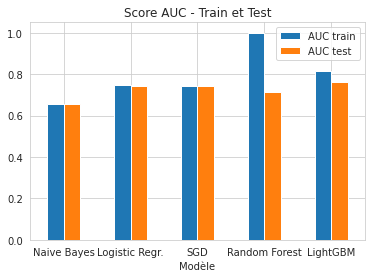

In [42]:
axs = results.plot.bar(y={"AUC train", "AUC test"}, x="Modèle", rot=0)
plt.title("Score AUC - Train et Test")
plt.show()

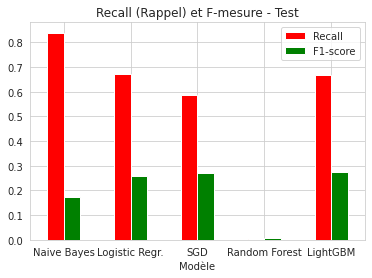

In [44]:
axs = results.plot.bar(y={"Recall", "F1-score"}, x="Modèle", rot=0, 
                       color={"Recall":"red", "F1-score":"green"})
plt.title("Recall (Rappel) et F-mesure - Test")
plt.show()

Text(0.5, 1.0, "Temps d'apprentissage et de prédiction")

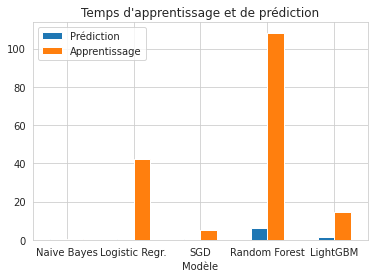

In [45]:
axs = results.plot.bar(y={"Apprentissage", "Prédiction"}, x="Modèle", rot=0)
plt.title("Temps d'apprentissage et de prédiction")

Le modèle avec les meilleures performances reste <code>LightGBM</code>.

In [46]:
# Libérer la mémoire
del data
del model_gnb, gnb, auc_train_gnb, auc_test_gnb, recall_gnb, f1_gnb, fit_time_gnb, score_time_gnb
del model_lr, lr, auc_train_lr, auc_test_lr, recall_lr, f1_lr, fit_time_lr, score_time_lr
del model_sgd, sgd, auc_train_sgd, auc_test_sgd, recall_sgd, f1_sgd, fit_time_sgd, score_time_sgd
del model_rfc, rfc, auc_train_rfc, auc_test_rfc, recall_rfc, f1_rfc, fit_time_rfc, score_time_rfc
del model_lgbm, lgbm, auc_train_lgbm, auc_test_lgbm, recall_lgbm, f1_lgbm, fit_time_lgbm, score_time_lgbm
gc.collect()

6386

## <font color=green>2.3 - Modèle final : Optimisation, prédictions et ROC Curve</font>

Dans cette partie, nous allons :
- Spécifier un/des métrique(s) comme objectif dans GridSearch : nous choisissons "roc_auc" ;
- Entraîner le modèle final ;
- Représenter graphiquement la courbe ROC.

### <font color=blue>2.3.1 - Optimisation des hyperparamètres</font>

Dans cette partie, nous allons essayer d'améliorer les résultats de notre meilleur modèle en optimisant ses hyperparamètres.

Nous allons <code>**GridSearchCV**</code> pour évaluer la meilleure combinaison de notre grille de paramètre.

In [47]:
# https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/
# Créer le modèle à optimiser
lightgbm = LGBMClassifier(random_state=random_state, 
                          class_weight=class_weight, 
                          objective="binary")

# Afficher les valeurs en cours des paramètres
# lightgbm.get_params()

In [48]:
# Créer les espaces de recherche (space search) des hyperparamètres
params_grid_lgbm = {"n_estimators":[500, 1000], 
                    "max_depth":[8, 12], 
                    "learning_rate":[0.01, 0.02], 
                    "num_leaves":[30, 50]}

# Créer le Grid Search
gscv_lgbm = GridSearchCV(lightgbm, 
                         params_grid_lgbm, 
                         cv=cv, 
                         scoring=scoring, 
                         refit="auc",
                         verbose=verbose, 
                         n_jobs=n_jobs)

# Lancer le Grid Search
best_lightgbm = gscv_lgbm.fit(X_train, y_train)

# Visualiser les meilleures valeurs des hyperparamètres
print("Meilleur de l'estimateur : ", best_lightgbm.best_estimator_)
print("Meilleurs paramètres : ", best_lightgbm.best_params_)
print("Meilleur score : ", best_lightgbm.best_score_)

Meilleur de l'estimateur :  LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.02, max_depth=12, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=500,
               n_jobs=-1, num_leaves=30, objective='binary', random_state=42,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)
Meilleurs paramètres :  {'learning_rate': 0.02, 'max_depth': 12, 'n_estimators': 500, 'num_leaves': 30}
Meilleur score :  0.7620787084173278


### <font color=blue>2.3.2 - Prédictions</font>

In [49]:
# Créer et entraîner le modèle final avec les paramètres optimisés
final_lgbm = LGBMClassifier(random_state=42, class_weight="balanced", 
                            objective="binary", 
                            learning_rate=0.02, max_depth=12, 
                            n_estimators=500, num_leaves=30, 
                            verbose=0, n_jobs=-1).fit(X_train, y_train)

# PREDICTIONS
# Prédire les valeurs binaires
y_pred_lgbm = final_lgbm.predict(X_test)
# Prédire les probabilités et retourner les résultats 1 uniquement
y_proba_lgbm = final_lgbm.predict_proba(X_test)[:,1]

# EVALUATION
# AUC
fp_lgbm, tp_lgbm, thresholds = roc_curve(y_test, y_proba_lgbm)
auc_lgbm = auc(fp_lgbm, tp_lgbm)
print("AUC - LightGBM = %f \n" % (auc_lgbm))

# Trouver le meilleur seuil de prédiction
# https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
from numpy import argmax

# Statistic J de Youden
# https://en.wikipedia.org/wiki/Youden%27s_J_statistic
J = tp_lgbm - fp_lgbm
ix = argmax(J)
best_thresh = thresholds[ix]
print("Meilleur seuil = %f \n" % (best_thresh))

# Rapport de classification
classif_report_lgbm = classification_report(y_test, y_pred_lgbm)
print("Classification Report - LightGBM :\n", classif_report_lgbm)

# Matrice de confusion
confusion_matrix_lgbm = confusion_matrix(y_test, y_pred_lgbm)
print("Confusion Matrix - LightGBM :\n", pd.DataFrame(confusion_matrix_lgbm, 
                                                      columns=["Prédit 0","Prédit 1"], 
                                                      index=["Réel 0", "Réel 1"]))

AUC - LightGBM = 0.767248 

Meilleur seuil = 0.469495 

Classification Report - LightGBM :
               precision    recall  f1-score   support

           0       0.96      0.71      0.82     56535
           1       0.17      0.68      0.28      4965

    accuracy                           0.71     61500
   macro avg       0.57      0.70      0.55     61500
weighted avg       0.90      0.71      0.78     61500

Confusion Matrix - LightGBM :
         Prédit 0  Prédit 1
Réel 0     40410     16125
Réel 1      1591      3374


**Observations** :
- L'**AUC** s'est amélioré : il est passé de 0,7604 à 0,7673 ; cela est-il suffisamment significatif ? 
- Notre **recall** est à 0,68, ce qui signifie que notre modèle fait des erreurs de **prédiction sur les Faux négatifs** (ceux qui sont classés comme solvables alors qu'ils ne le sont pas) de l'ordre de **32%** ; est-ce un taux suffisamment **raisonnable** sachant que c'est un risque qui peut générer une réelle perte financière ? 
- De même, notre **précision** est à 0,17, ce qui signifie que notre modèle fait des erreurs de **prédition sur les Faux positifs** (ceux qui sont classés comme non-solvables alors qu'ils ne le sont pas) de l'ordre de **83%** ; est-ce un taux suffisamment **raisonnable** sachant que c'est un risque qui peut générer un manque à gagner pour l'entreprise ?

Grand débat... 

Ce compromis entre rappel et précision - qui est représenté par la F1-score, reste un rapport de force permanent puisque l'amélioration du recall se fait au détriment de la précision, et inversément.

### <font color=blue>2.3.3 - ROC Curve</font>

La courbe ROC est un graphique qui représente les performances d'un modèle de classification pour tous les **seuils de classification**, qui est paramétré par défaut à 0,5.

La courbe trace le **taux de vrais positifs** en fonction du **taux de faux positifs**.
- Le **taux de vrais positifs** est l'équivalent du **recall** : VP / (VP+FN);
- Le **taux de faux positifs** est défini comme suit : FP / (FP+VN) = **0,28**.

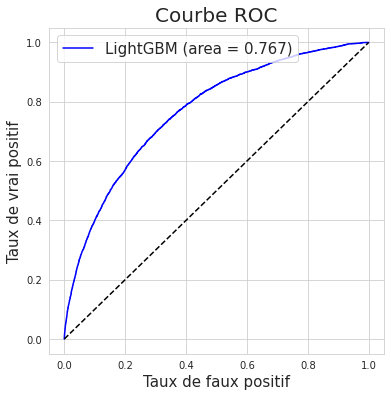

In [50]:
# ROC
roc_lgbm = roc_auc_score(y_test, y_proba_lgbm)

# Représenter graphiquement la courbe ROC
plt.figure(figsize=(6, 6))
plt.plot(fp_lgbm, tp_lgbm, "b-", label="LightGBM (area = %0.3f)" % roc_lgbm)
# L'aléatoire avec un auc à 0.5
plt.plot([0, 1], [0, 1],"k--")
plt.xlabel("Taux de faux positif", fontsize=15)
plt.ylabel("Taux de vrai positif", fontsize=15)
plt.title("Courbe ROC", fontsize=20)
plt.legend(loc="upper left", fontsize=15)
plt.show()

## <font color=green>2.4 - Métrique business</font>

En complément de la probabilité de défaut de paiement prédit par le modèle, les chargés de clientèle peuvent adosser leur décision à une métrique business. 

En effet, pour l'entreprise Prêt-à-dépenser, il existe :
- une **perte réelle** due aux faux négatifs, qui sont considérés comme solvables alors qu'ils ne vont pas pouvoir rembourser leur prêt, donc faire perdre de l'argent à l'entreprise ;
- de même, il existe un **manque à gagner réel (*ou une perte d'opportunité*)** dû aux faux positifs, qui sont considérés comme non-solvables alors qu'il peuvent rembourser leur prêt, donc faire gagner de l'argent à l'entreprise.

<font color=blue> En effet, le chargé de clientèle va-t-il accorder ou refuser un prêt si le pourcentage est de 55%, même s'il a l'expertise métier ? Comment évalue-t-il et minimise-t-il le risque pour l'entreprise?</font>

En tant que Data Scientist, à défaut de connaître la réalité métier, émettons quelques hypothèses, **pour un montant de prêt M** :
- la **perte** pour un prêt non-remboursé est de **pe=70%** ;
- le **gain** sur la durée de vie d'un prêt remboursé est de **gn=20%**.

En cas d'erreur de classification, on pourrait dire que :
- **perte réelle = M x pe x p(FN)** *où p(FN) = nb FN / totalité des individus*
- **manque à gagner = M x gn x p(FP)** *où p(FP) = nb FP / totalité des individus*
- **Perte totale** = perte réelle + manque à gagner

**Exemple** : pour un prêt de M = 100.000
- perte réelle = 100000 x 70% x (1591 / 61500) = 70000 x **2,59%** = 1813
- manque à gagner = 100000 x 20 x (16125 / 61500) = 20000 x **26,22%** = 5244
- perte totale = 1813 + 5244 = 7057

On peut voir dans le tableau suivant les pertes subies par seuil de classification :

In [51]:
# Utiliser les données de l'exemple
amount_loan = 100000
loss_per_default = 0.7
gain_no_default = 0.2

# Vérifier les pertes par seuil
seuil = []
perte_reelle = []
manque_gain = []
perte_totale = []

for x in np.linspace(0,1,50):
    predictions = final_lgbm.predict_proba(X_test)[:,1] > x
    cm = confusion_matrix(y_test, predictions)
    pcm = cm/np.sum(cm)
    perte = round(amount_loan * loss_per_default * pcm[1,0], 2)
    manque = round(amount_loan * gain_no_default * pcm[0,1], 2)
    total = perte + manque
    seuil.append(x)
    perte_reelle.append(perte)
    manque_gain.append(manque)
    perte_totale.append(total)

df_credit = pd.DataFrame({"seuil": seuil, 
                      "perte nette":perte_reelle, 
                      "opport. manquée":manque_gain, 
                      "perte ttle":perte_totale})

df_credit

,seuil,perte nette,opport. manquée,perte ttle
0,0.000000,0.00,18385.37,18385.37
1,0.020408,0.00,18385.37,18385.37
2,0.040816,0.00,18372.68,18372.68
3,0.061224,0.00,18285.53,18285.53
4,0.081633,2.28,18055.28,18057.56
5,0.102041,15.93,17695.61,17711.54
6,0.122449,27.32,17217.89,17245.21
7,0.142857,68.29,16654.96,16723.25
8,0.163265,104.72,16000.65,16105.37
9,0.183673,149.11,15308.29,15457.40


Et on peut tracer sur un graphique les pertes subies, ainsi que la valeur du seuil optimal (pour une perte totale minimale).

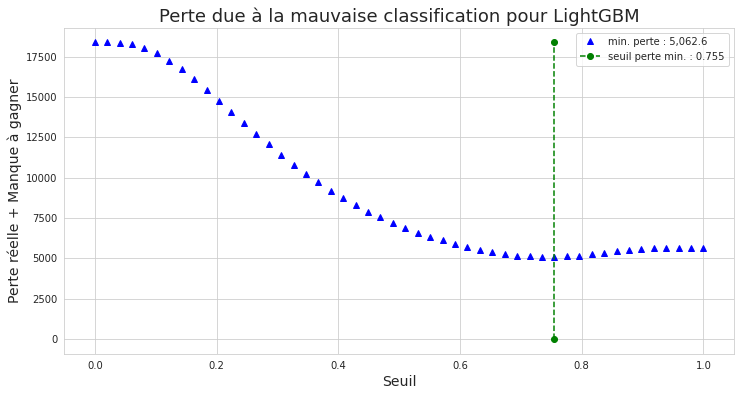

In [52]:
min_perte = round(df_credit["perte ttle"].min(), 3)
idx_min = perte_totale.index(min(perte_totale))
seuil_min_perte = round(seuil[idx_min], 3)

plt.figure(figsize=(12,6))
plt.plot(df_credit["seuil"], df_credit["perte ttle"], "b^", label= "min. perte : {:,}".format(min_perte))
plt.plot([seuil_min_perte, seuil_min_perte], [0, max(perte_totale)], "go-", 
         label = "seuil perte min. : {:0.3f}".format(seuil_min_perte), linestyle="dashed")
plt.legend(loc="upper right")
plt.title("Perte due à la mauvaise classification pour LightGBM", fontsize=18)
plt.ylabel("Perte réelle + Manque à gagner", fontsize=14)
plt.xlabel("Seuil", fontsize=14)
plt.show()

Cette métrique business est une estimation évidemment qui dépend de plusieurs paramètres :
- la façon dont le modèle prédit le défaut de paiement, influant fortement p(FN) et p(FP) ;
- la valeur des taux estimés de perte ou de gain, sachant qu'un défaut de paiment peut intervenir à tout moment dans la durée de vie du prêt par exemple ;
- potentiellement du seuil de classification choisi en amont.

Tout cela devra être discuté avec les experts métiers pour valider la consistence du raisonnement.

# <font color=red>PARTIE 3 - INTERPRETABILITE DU MODELE</font>

Les modèles de Machine Learning sont souvent considérés comme des **black boxes** (boîtes noires), difficiles à comprendre. 

Il existe plusieurs librairies (LIME, SHAP, XplainableAI, etc.) permettant de faciliter l'interprétabilité d'un modèle, c'est-à-dire d'expliquer le résultat prédit par le modèle, et notamment, quelles caractéristiques permettent de prédire avec précision ou l'inverse.

L'**interprétabilité d'un modèle** sert 4 objectifs majeurs :
- La possibilité pour les Data Scientist à valider la cohérence du modèle, déterminer quand et pourquoi le modèle se trompe, déboguer leurs modèles et prendre des décisions éclairées sur la manière de les améliorer ;
- La capacité par les Data Scientist à expliquer leurs modèles aux parties prenantes (dirigeants, métier, etc.) afin que ces dernières puissent avoir confiance dans le modèle, et comprendre la valeur et la précision des découvertes ;
- La facilité pour les Décisionnaires en entreprise (ex: chargé de relation client) d'être transparent envers les utilisateurs finaux et de pouvoir justifier les décisions ;
- La confirmation pour les auditeurs juridiques du respect des principes réglementaires (CNIL, RGPD,..) et de la surveillance de l'impact des décisions des modèles sur les êtres humains.

Dans cette partie, nous allons utiliser la librairie **<font color=red>SHAP (SHapley Additive exPlanations)** pour nous aider à mieux interpréter notre modèle final (***LightGBM***).
    
Cela se fait en extrayant les informations du modèle afin de comprendre ses prédictions :
- soit globalement, pour expliquer sur quoi se base le modèle pour prédire ;
- soit localement pour expliquer chaque décision.
    
**SHAP** permet d'expliquer les prédictions en calculant la **contribution** de chaque feature (variable) à cette prédiction.
    
A noter qu'il faut utiliser un modèle **déjà entraîné**.

In [54]:
# Pour interpréter les modèles
!pip install shap

     |████████████████████████████████| 327kB 8.2MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463907 sha256=39d6c8a26f494054193ade6f20279d9efc3981c0757fd0d9f059ba3381df82bc
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap


In [55]:
import shap

# Charger la visualisation de code JS dans le notebook
shap.initjs()

## <font color=green>3.1 - Génération des valeurs d'importance des caractéristiques</font>

La méthode SHAP a été conçue comme vérifiant trois propriétés jugées nécessaires afin d’expliquer correctement un modèle :
- Les variables nulles sont sans effet, n'ont pas d'impact (*Missingness*) ;
-  Cohérence (*Consistency*) : si un modèle change, tel que l’effet d’une variable est plus important sur le modèle, l’attribution assignée à cette variable ne doit pas baisser ;
- Additivité (*Local accuracy*) : la somme des effets des variables est égale à la prédiction du modèle pour toutes les exemples.

In [56]:
# INTERPRETATION DES PREDICTIONS DU MODELE
# Créer l'objet TreeExplainer pour expliquer l'arbre de décision
explainer = shap.TreeExplainer(final_lgbm, X_train, model_output="probability", feature_perturbation ="interventional")
shap_values = explainer.shap_values(X_train)

100%|===================| 245997/246000 [127:11<00:00]       

## <font color=green>3.2 - Mesure de l'importance globale des variables</font>

Le graphique **summary plot** est l'un des plus importants des graphiques disponibles dans la librairie **SHAP**, car il représente la distribution des **20 plus importantes features (variables)** de notre modèle, et la façon dont chacune d'elles influence le résultat du modèle :
- Plus les points sont **rouges**, plus la valeur de l'élément est **élevée (high)**; 
- Plus les points sont **bleus**, plus la valeur de l'élément est **faible (low)**.

SHAP calcule, pour chaque donnée, l’importance de chaque variable et fait la moyenne des importances afin d’avoir des importances « globales » pour chaque variable.

In [57]:
# Transformer X_train d'array en dataframe pour récupérer les noms des colonnes
X_train_df = pd.DataFrame(X_train, columns=X.columns)

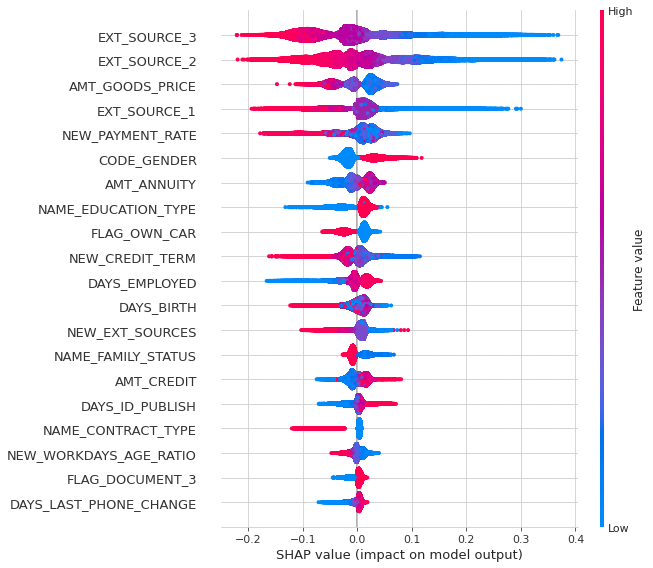

In [58]:
# Représenter l'importance des variables
shap.summary_plot(shap_values, X_train_df)

## <font color=green>3.3 - Explication locale</font>

Cette partie répond à la question : **quelles variables causent cet évènement particulier** ?

Ci-dessous, nous avons 3 prédictions de défaut de paiement :
- à 72% ;
- à 32%
- à 9%

In [60]:
# Tester sur une observation
i = 5
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[i,:], X_train_df.iloc[i,:])

In [61]:
# Tester sur une observation
i = 4
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[i,:], X_train_df.iloc[i,:])

In [62]:
# Tester sur une observation
i = 2
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[i,:], X_train_df.iloc[i,:])

# <font color=red>CONCLUSION</font>

La construction d'un modèle de Machine Learning requiert de nombreuses transformations et ajustements.

Dans ce notebook, nous avons construit les bases d'un bon modèle :
- Préparation des données ;
- Compréhension de la problématique métier ;
- Sélection des métriques adaptés ;
- Equilibrage des données du fait de la présence de classes majoritaire et minoritaires ;
- Test de plusieurs modèles et choix d'un modèle final ;
- Optimisation des hyperparamètres du modèle final ;
- Interprétabilité et métrique business....

Mais nous sommes bien conscients que les résultats du modèle **dépendent fortement** des transformations et traitements effectués, et également des choix sur les paramètres des méthodes et du modèle lui-même.<br><br>

Nous pouvons certainement améliorer la performance en axant nos futurs travaux :
- sur le développement d'une meilleure **compréhension du business** auprès des chargés de clientèle pour une meilleure préparation des données ;
- sur l'**approfondissement des mécanismes** sous-jacents des différents modèles afin de mieux optimiser les paramètres influents ;
- sur l'**expérimentation des différentes techniques** de sélection de features, de rééquilibrage des données (upsampling / downsampling), d'autres outils d'interprétation (ex: Lime), ou même juste d'un meilleur séquençage du code pour optimiser la performance générale, pas juste des résultats métier mais également de la démarche d'apprentissage en elle-même.

